In [1]:
import os
## The base dir of the project
PROJECT_DIR = "/home/projects/IBRS/Image-Based-Recommendation-System-with-ResNet-and-Elasticsearch"

## The "etc" dir contains all the files not tracked in GitHub
ETC_DIR = os.path.join(PROJECT_DIR, "etc")

## The .zip of the dataset is provided in the repository, but it's unzipped in "etc"
DATASET_ZIP_FILE = os.path.join(PROJECT_DIR, "dataset.zip")
DATASET_DIR = os.path.join(ETC_DIR, "dataset")
DATASET_METADATA_TXT_FILE = os.path.join(DATASET_DIR, "metadata.txt")
DATASET_METADATA_JSON_FILE = os.path.join(DATASET_DIR, "metadata.json")
DATASET_METADATA_DIR = os.path.join(DATASET_DIR, "metadata")

In [2]:
# unzip the dataset into the etc dir
import zipfile

if not os.path.exists(DATASET_DIR):
    with zipfile.ZipFile(DATASET_ZIP_FILE, 'r') as data:
        data.extractall(path=ETC_DIR)
else:
    print('[INFO] Dataset already unzipped')

[INFO] Dataset already unzipped


In [14]:
import json

metadata = []

if not os.path.exists(DATASET_METADATA_JSON_FILE):
    with open(DATASET_METADATA_TXT_FILE, 'r') as file :
        line = file.readline()
        while line:
            
            # read metadata of the current item
            item = eval(line.strip())
            
            metadata.append(item)
            
            # read the next line (next item)
            line = file.readline()
    
    with open(DATASET_METADATA_JSON_FILE, 'w') as file:
        json.dump(metadata, file)
else:
    print('[INFO] The JSON file already exists. Loading from disk')
    with open(DATASET_METADATA_JSON_FILE, 'r') as file:
        metadata = json.load(file)

[INFO] The JSON file already exists. Loading from disk


The metadata file contains a list of metadata, as shown in the following example

```json
[
  {
    "ID": 7541,
    "title": "Christina Gavioli",
    "slug": "christina-gavioli-3",
    "category": [
      "Fashion Women",
      "Women Blouse and Dress"
    ],
    "imPath": "images/Fashion Women/Women Blouse and Dress/CHRISTINA_GAVIOLI.jpg"
  },
]
```

## Create the Elasticsearch Mapping to index the Data

In this tutorial, I'm using Elasticsearch as the data store and the vector database. Elasticsearch can perform vector or similarity search using KNN.

Define the property that will hold the embedding vector
```json
"image_features": {
    "type": "dense_vector",
    "dims": 2048,
    "index": true,
    "similarity": "cosine"
}
```
* `dims`: The dimension should be the actual dimension of your dense vector.
* `index`: When ***true*** (the default value), ES can perform vector search. It then creates an HNSW (Hierarchical Navigable Small World) index that is used to perform vector search. When it is set to ***false***, ES just stores vectors but does not perform vector search using KNN. Useful only for storing embeddings for external processing. 
* `similarity`: The default value is ***cosine***. It defines the similarity metric that ES will use for vector search. Other metrics: *dot_product*, *l2_norm*

Vector store is available from version 8+. Here, I'm using version 9.1.8.

Please read https://www.elastic.co/docs/deploy-manage/production-guidance/optimize-performance/approximate-knn-search for what should be considered when using vector search in an index mode with Elasticsearch

In [10]:
# define the mapping
mapping = {
  "mappings": {
    "properties": {
      "ID": {
        "type": "integer"
      },
      "title": {
        "type": "text",
        "fields": {
          "keyword": {
            "type": "keyword"
          }
        }
      },
      "slug": {
        "type": "text",
        "fields": {
          "keyword": {
            "type": "keyword"
          }
        }
      },
      "category": {
        "type": "keyword"
      },
      "imPath": {
        "type": "keyword"
      },
      "image_features": {
        "type": "dense_vector",
        "dims": 2048,
        "index": True,
        "similarity": "cosine"
      }
    }
  }
}


In [11]:
# create the mapping using the Elasticsearch Python API
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")

index_name = "items"

if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=mapping)
    print("[INFO] Mapping create.")

[INFO] Mapping create.


In [16]:
metadata[0]

{'ID': 7541,
 'title': 'Christina Gavioli',
 'slug': 'christina-gavioli-3',
 'category': ['Fashion Women', 'Women Blouse and Dress'],
 'imPath': 'images/Fashion Women/Women Blouse and Dress/CHRISTINA_GAVIOLI.jpg'}

In [17]:
# indexing the data in Elasticsearch

from elasticsearch.helpers import bulk

actions = [
    {
        "_index": index_name,
        "_id": item["ID"],
        "_source": item
    }
    for item in metadata
]

bulk(es, actions)
print("[INFO] Document indexed successfully")

Initial documents indexed (without embeddings)


In [18]:
es.search()

ObjectApiResponse({'took': 132, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1655, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'items', '_id': '7541', '_score': 1.0, '_source': {'ID': 7541, 'title': 'Christina Gavioli', 'slug': 'christina-gavioli-3', 'category': ['Fashion Women', 'Women Blouse and Dress'], 'imPath': 'images/Fashion Women/Women Blouse and Dress/CHRISTINA_GAVIOLI.jpg'}}, {'_index': 'items', '_id': '7540', '_score': 1.0, '_source': {'ID': 7540, 'title': 'Sexy Woman', 'slug': 'sexy-woman-3', 'category': ['Fashion Women', 'Women Blouse and Dress'], 'imPath': 'images/Fashion Women/Women Blouse and Dress/SEXY_WOMAN_MULTICOLORE.jpg'}}, {'_index': 'items', '_id': '7539', '_score': 1.0, '_source': {'ID': 7539, 'title': 'Sexy Woman', 'slug': 'sexy-woman-2', 'category': ['Fashion Women', 'Women Blouse and Dress'], 'imPath': 'images/Fashion Women/Women Blouse and Dress/SEXY_WOMAN_JAUNE.jpg'}}, {'_i

## Extract Embeddings Using ResNet50

In [20]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model

import numpy as np

# initialize the resnet model with the imagenet weights. you can user resnet.summary() to see the model structure
resnet = resnet50.ResNet50(weights='imagenet')

# create a submodel from the resnet model
resnet_embeddings_extractor = Model(inputs=resnet.inputs, outputs=resnet.get_layer('avg_pool').output)

# uncomment the code below to see the resnet_embeddings_extractor structe
#resnet_embeddings_extractor.summary()

In [22]:
def load_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0) # Reshape (1, 224, 224, 3)

def preprocess_batch(img_arrays):
    batch = np.stack(img_arrays, axis=0)
    return preprocess_input(batch)

def extract_embeddings_batch(paths):
    imgs = [load_image(path) for path in paths]
    batch = preprocess_batch(imgs)
    return resnet_embeddings_extractor.predict(batch, verbose=0)

def bulk_update_embeddings(es_client, items, embeddings):
    actions = []

    for item, vector in zip(items, embeddings):
        actions.append({
            "_op_type": "update",
            "_index": index_name,
            "_id": item["_id"],
            "doc": {
                "image_features": vector.flatten().tolist()
            }
        })

    bulk(es_client, actions)
    print(f"[INFO] updated {len(actions)} documents")

In [24]:
# Fetch items from Elasticsearch
query = {
    "size": 64,
    "query": {
        "bool": {
            "must_not": {
                "exists": {"field": "image_features"}
            }
        }
    }
}

response = es.search(
    index=index_name,
    body=query,
    scroll="5m"
)

scroll_id = response["_scroll_id"]

while True:
    hits = response["hits"]["hits"]

    if not hits:
        break

    # batch processing
    paths = [os.path.join(DATASET_DIR, hit["_source"]["imPath"]) for hit in hits]
    embeddings = extract_embeddings_batch(paths)
    bulk_update_embeddings(es, hits, embeddings)

    # continue scrolling
    response = es.scroll(scroll_id=scroll_id, scroll="5m")

print("DONE: all embeddings updated.")

2025-12-05 19:05:47.432929: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-05 19:05:47.539312: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2025-12-05 19:05:47.591642: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-05 19:05:47.670582: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-05 19:05:47.814762: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 64 documents
Updated 55 documents
DONE: all embeddings updated.


## Perform Recommendations

* knn search with filter ref: https://www.elastic.co/docs/solutions/search/vector/knn#knn-search-filter-example

In [62]:
item_ids = [item['ID'] for item in metadata]

def knn_search(item_id, k=10, num_candidates=100, apply_filter=False):
    # Query Elasticsearch to get all the fields of the referenced item 
    res = es.get(index=index_name, id=item_id)
    ref_item = res['_source']

    # build the knn query. Add filter on category if apply_filter is enable
    knn_query = {
        "knn": {
            "field": "image_features",
            "query_vector": ref_item['image_features'],
            "k": k,
            "num_candidates": num_candidates
        }
    }

    
    if apply_filter:
        knn_query["knn"]["filter"] = {
            "term": {
                "category": ref_item['category'][0]
            }
        }
        
    # execute the knn query
    res = es.search(index=index_name, query=knn_query)
    knn_items = res['hits']['hits']
    return ref_item, knn_items

In [86]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def display_knn(knn_items, ref_item=None, src_img_path=None):
    # size of images in the grid
    fig = plt.figure(figsize = (16,3))
    
    # get image of the referenced item and display it in the matplotlib grid
    if ref_item is not None:
        ref_item_img = mpimg.imread(os.path.join(DATASET_DIR, ref_item['imPath']))
    elif src_img_path is not None:
        ref_item_img = mpimg.imread(src_img_path)
    else:
        raise ValueError('Expected ref_item or src_img_path, got None for both.')
    
    axis = []
    axis.append(fig.add_subplot(2,10,1))

    # display the referenced item
    axis[0].imshow(ref_item_img)
    plt.axis("off")
    
    # display the knn items: loop over the knn items and display their images
    for i, knn_item in enumerate(knn_items):
        knn_img = os.path.join(DATASET_DIR, knn_item['_source']['imPath'])
        axis.append(fig.add_subplot(2,10,i+11))
        axis[i+1].imshow(mpimg.imread(knn_img))
        plt.axis("off")
    
    # display the grid
    plt.show()

def make_recommendations(item_id):
    ref_item, knn_items = knn_search(item_id=item_id)
    display_knn(knn_items, ref_item=ref_item)

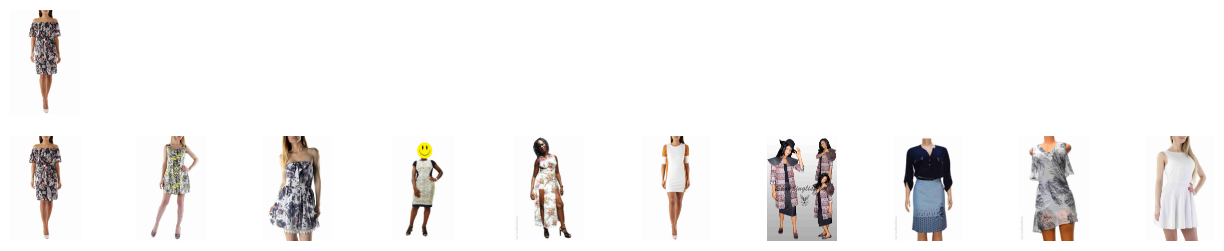

In [87]:
make_recommendations(item_id=7541)

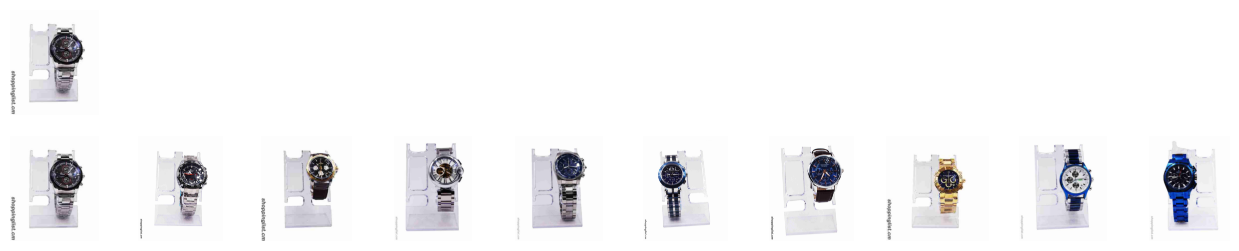

In [88]:
make_recommendations(item_id=6214)

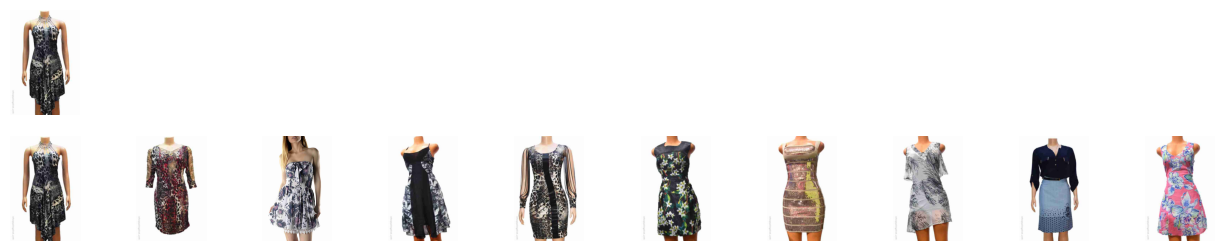

In [89]:
make_recommendations(item_id=5817)

In [90]:
import random
def random_item_search():
    # randomly select an item
    random_item_id = random.choice(item_ids)
    print(f"item id: {random_item_id}")

    # run the knn_search for the ref item
    item, knns = knn_search(item_id=random_item_id)

    # display the results.
    display_knn(knns, ref_item=item)

item id: 5386


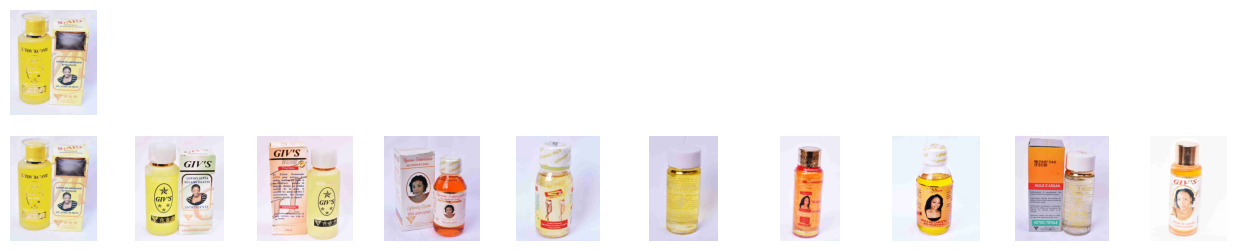

In [91]:
# explore other recommendations
random_item_search()

## Image-based Search Engine

In [105]:
img_paths = [os.path.join(DATASET_DIR, 'img1.jpg')]

img_vectors = extract_embeddings_batch(paths=img_paths)

In [106]:
def knn_search(src_vector, k=10, num_candidates=100):

    # build the knn query. Add filter on category if apply_filter is enable
    knn_query = {
        "knn": {
            "field": "image_features",
            "query_vector": src_vector,
            "k": k,
            "num_candidates": num_candidates
        }
    }
        
    # execute the knn query
    res = es.search(index=index_name, query=knn_query)
    knn_results = res['hits']['hits']
    return knn_results

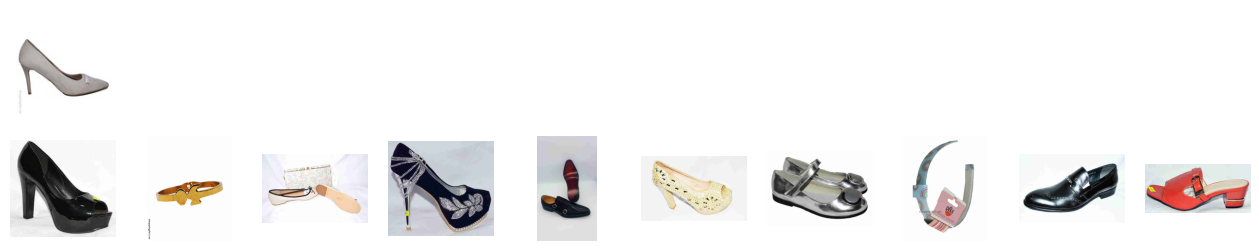

In [107]:
knn_results = knn_search(img_vectors[0])
display_knn(knn_items=knn_results, src_img_path=img_paths[0])